In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
import itertools
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set()
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly import figure_factory as FF

from __future__ import print_function

from sklearn.datasets import make_blobs
import matplotlib.cm as cm
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Prompt: 

# A) Search result quality:
        -Based on the data, what types of pros are customers interested in?
        -How would you describe the quality of the search results?
        -What could be improved?

 # B) Pricing:
        -By category, what price do you think Thumbtack should charge pros for each customer contact? 
        -Please justify your answer using the data provided, and explain any assumptions that you make.

In order to answer this prompt, will follow CRISP-DM (cross-industry process for data mining) methodology loosely.

## 1a. Business understanding

### What we need to accomplish:
    Improve Customer (Search Result) and Service Professional (Pricing) experiences on platform.
    
    At this point, the only competing objective is that the higher the price that a service professional posts, the higher the likelihood that the customer will not pick them. At the same time, need to consider market's condition such as seasonality, week, events and competition's behavior. These affect what price is set with the goal of optimizing revenue. Given that the categories explored are House Cleaning and Local Moving, typical end users would be those from a college town. Before the academic year and at the end of it, people move out and move in which both require Local Moving and House Cleaning.

## 2a. Data Understanding

The first table, **visitors**, is a dataset that contains a list of search results. Each result is a pro that matched a specific visitor's search.

In [2]:
visitors = pd.read_csv("visitors.csv")
visitors.head(5)

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed
0,15173,344101422347558000,2018-11-26 15:43:43.365 UTC,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,NaN,6,False
1,8426,344461605879021000,2018-11-30 19:46:46.593 UTC,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809 UTC,8900.0,6,False
2,12809,344142189241475000,2018-11-27 03:03:09.969 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,21,False
3,17310,344215295106097000,2018-11-27 23:21:35.89 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,22,False
4,10072,344364289304010000,2018-11-29 16:44:50.202 UTC,House Cleaning,343934345272852000,0,NaN,NaN,9000.0,13,False


In [3]:
visitors.tail(5)

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed
26097,17765,344404210763063000,2018-11-30 03:50:11.345 UTC,Local Moving (under 50 miles),272345585989305000,249,4.493976,2018-11-30 03:43:54.951 UTC,7400.0,1,False
26098,14259,343277153447100000,2018-11-17 02:45:54.125 UTC,House Cleaning,258980375474922000,251,4.693227,2018-11-17 01:34:10.596 UTC,7500.0,1,False
26099,1490,343087749834981000,2018-11-14 22:09:10.472 UTC,Local Moving (under 50 miles),216681723444741000,254,4.661417,2018-11-14 20:32:17.354 UTC,8000.0,1,False
26100,4087,343081700706951000,2018-11-14 20:28:21.285 UTC,Local Moving (under 50 miles),216681723444741000,254,4.661417,2018-11-14 20:10:00.722 UTC,8000.0,1,False
26101,23857,343082021140471000,2018-11-14 20:33:41.805 UTC,Local Moving (under 50 miles),216681723444741000,254,4.661417,2018-11-14 20:32:17.354 UTC,8000.0,1,False


In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26102 entries, 0 to 26101
Data columns (total 11 columns):
row_number                            26102 non-null int64
visitor_id                            26102 non-null int64
search_timestamp                      26102 non-null object
category                              26102 non-null object
pro_user_id                           26102 non-null int64
num_reviews                           26102 non-null int64
avg_rating                            24947 non-null float64
pro_last_active_time_before_search    25035 non-null object
cost_estimate_cents                   23944 non-null float64
result_position                       26102 non-null int64
service_page_viewed                   26102 non-null bool
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 2.0+ MB


In [5]:
visitors.isnull().sum()

row_number                               0
visitor_id                               0
search_timestamp                         0
category                                 0
pro_user_id                              0
num_reviews                              0
avg_rating                            1155
pro_last_active_time_before_search    1067
cost_estimate_cents                   2158
result_position                          0
service_page_viewed                      0
dtype: int64

Around 4-8% of missing data per category with NaN's. This is important to note since missing data will impact analysis conclusions. In order to remedy this, **data can be taken out** without severe impact on original dataset.

In [6]:
visitors['search_timestamp'].min(), visitors['search_timestamp'].max()

('2018-10-01 00:40:53.592 UTC', '2018-11-30 23:46:21.613 UTC')

This dataset spans from beginning of October to the end of November (61 days) in 2018.

In [7]:
visitors.category.unique() #Only these categories are included in dataset

array(['Local Moving (under 50 miles)', 'House Cleaning'], dtype=object)

The second table, **contacts**, containts a list of customers reaching out to pros. Each row is a visitor that reached out to a pro through a search in the visitors CSV.

In [8]:
contacts = pd.read_csv("contacts.csv")
contacts.head()

,visitor_id,pro_user_id,contact_id,hired
0,339909111505494000,269676229116822000,339909524915273000,False
1,344128984608088000,343705945283207000,344129090535645000,False
2,344283283738624000,198869800397579000,344283629941841000,False
3,342932176648061000,198869800397579000,342932549106393000,False
4,344288410954719000,198869800397579000,344288499619061000,False


In [9]:
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 4 columns):
visitor_id     1504 non-null int64
pro_user_id    1504 non-null int64
contact_id     1504 non-null int64
hired          1504 non-null bool
dtypes: bool(1), int64(3)
memory usage: 36.8 KB


In [10]:
contacts.isnull().sum()

visitor_id     0
pro_user_id    0
contact_id     0
hired          0
dtype: int64

In [11]:
#Merge Visitors and Contacts tables together so all information for visitor_id is one dataset.
combo = pd.merge(visitors, contacts, on='visitor_id', how='left')
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26574 entries, 0 to 26573
Data columns (total 14 columns):
row_number                            26574 non-null int64
visitor_id                            26574 non-null int64
search_timestamp                      26574 non-null object
category                              26574 non-null object
pro_user_id_x                         26574 non-null int64
num_reviews                           26574 non-null int64
avg_rating                            25382 non-null float64
pro_last_active_time_before_search    25476 non-null object
cost_estimate_cents                   24340 non-null float64
result_position                       26574 non-null int64
service_page_viewed                   26574 non-null bool
pro_user_id_y                         13080 non-null float64
contact_id                            13080 non-null float64
hired                                 13080 non-null object
dtypes: bool(1), float64(4), int64(5), object(4)
memor

In [12]:
combo.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
0,15173,344101422347558000,2018-11-26 15:43:43.365 UTC,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,NaN,6,False,2.875081e+17,3.441018e+17,False
1,8426,344461605879021000,2018-11-30 19:46:46.593 UTC,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809 UTC,8900.0,6,False,NaN,NaN,NaN
2,12809,344142189241475000,2018-11-27 03:03:09.969 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,21,False,3.402292e+17,3.441425e+17,False
3,17310,344215295106097000,2018-11-27 23:21:35.89 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,22,False,NaN,NaN,NaN
4,10072,344364289304010000,2018-11-29 16:44:50.202 UTC,House Cleaning,343934345272852000,0,NaN,NaN,9000.0,13,False,NaN,NaN,NaN


# Assumptions made on data:

1. Search has pre-made categories in order to better guarantee searcher's intent in search results.

2. Landing on service_page_viewed would lead to ability for pro to be hired (True/1). However, that is not the case with data since for some True/1 values in hired column, service_page_valued is False. This is conflicting information if assumption is that user lands on service_page_viewed in order to hire a pro.

## 3a. Before Model building: Data Preparation

In [13]:
combo.isnull().sum()

row_number                                0
visitor_id                                0
search_timestamp                          0
category                                  0
pro_user_id_x                             0
num_reviews                               0
avg_rating                             1192
pro_last_active_time_before_search     1098
cost_estimate_cents                    2234
result_position                           0
service_page_viewed                       0
pro_user_id_y                         13494
contact_id                            13494
hired                                 13494
dtype: int64

First, get rid of any rows with NaN's since they are gaps in data. And these are not helpful where model needs data points.
At most, 50% of the data for last columns are NaN's. Due to this significant amount, will change NaN's to 0 here and get rid of rows from remaining columns that have NaN's. These last columns only have at most 8% NaN's, which is small fraction of the whole dataset.

In [14]:
combo['pro_user_id_y'] = combo['pro_user_id_y'].fillna(0)
combo['contact_id'] = combo['contact_id'].fillna(0)
combo['hired'] = combo['hired'].fillna(0)

In [15]:
combo.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
0,15173,344101422347558000,2018-11-26 15:43:43.365 UTC,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,NaN,6,False,2.875081e+17,3.441018e+17,False
1,8426,344461605879021000,2018-11-30 19:46:46.593 UTC,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809 UTC,8900.0,6,False,0.000000e+00,0.000000e+00,0
2,12809,344142189241475000,2018-11-27 03:03:09.969 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,21,False,3.402292e+17,3.441425e+17,False
3,17310,344215295106097000,2018-11-27 23:21:35.89 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,22,False,0.000000e+00,0.000000e+00,0
4,10072,344364289304010000,2018-11-29 16:44:50.202 UTC,House Cleaning,343934345272852000,0,NaN,NaN,9000.0,13,False,0.000000e+00,0.000000e+00,0


In [16]:
combo.isnull().sum()

row_number                               0
visitor_id                               0
search_timestamp                         0
category                                 0
pro_user_id_x                            0
num_reviews                              0
avg_rating                            1192
pro_last_active_time_before_search    1098
cost_estimate_cents                   2234
result_position                          0
service_page_viewed                      0
pro_user_id_y                            0
contact_id                               0
hired                                    0
dtype: int64

At most, will be getting rid of 2234/26574 = **.08 (8%)** of the dataset in order to clean up the data.

In [17]:
combo = combo.dropna()

In [18]:
combo.isnull().sum()

row_number                            0
visitor_id                            0
search_timestamp                      0
category                              0
pro_user_id_x                         0
num_reviews                           0
avg_rating                            0
pro_last_active_time_before_search    0
cost_estimate_cents                   0
result_position                       0
service_page_viewed                   0
pro_user_id_y                         0
contact_id                            0
hired                                 0
dtype: int64

In [19]:
combo.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
1192,357,344424403697885000,2018-11-30 09:26:44.332 UTC,Local Moving (under 50 miles),238282986977690000,768,4.726562,2018-11-30 00:45:27.675 UTC,10000.0,2,False,0.000000e+00,0.000000e+00,0
1193,633,344449563130871000,2018-11-30 16:26:03.803 UTC,Local Moving (under 50 miles),238282986977690000,768,4.726562,2018-11-30 12:29:39.577 UTC,10000.0,2,False,2.168535e+17,3.444497e+17,False
1194,2067,344452204695699000,2018-11-30 17:10:05.374 UTC,Local Moving (under 50 miles),238282986977690000,768,4.726562,2018-11-30 12:29:39.577 UTC,10000.0,2,False,0.000000e+00,0.000000e+00,0
1195,4451,344451541216354000,2018-11-30 16:59:01.908 UTC,Local Moving (under 50 miles),238282986977690000,768,4.726562,2018-11-30 12:29:39.577 UTC,10000.0,2,False,2.168535e+17,3.444519e+17,False
1196,7805,344383956301447000,2018-11-29 22:12:37.072 UTC,Local Moving (under 50 miles),238282986977690000,768,4.726562,2018-11-29 21:51:17.994 UTC,10000.0,2,True,2.382830e+17,3.443848e+17,True


Resort dataframe based on rank in descending order.

In [20]:
combo = combo.sort_values(by='result_position')

Now, with sorted table, can see if there are some strong correlations between rank and say, num_review, avg_rating, etc.
Correlation coefficient will be used here.
And in order to get valid output (no NaN's), need to make sure involved columns are not only numeric, but vary as well. 

In [21]:
combo.hired = combo.hired.astype(int)
combo.hired.value_counts()

0    20086
1     2879
Name: hired, dtype: int64

In [22]:
combo.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
14372,11429,343551779478224000,2018-11-20 07:03:00.015 UTC,Local Moving (under 50 miles),293111039149301000,14,5.0000,2018-11-19 14:12:09.54 UTC,9000.0,1,False,0.000000e+00,0.000000e+00,0
18745,8761,340891335765336000,2018-10-20 12:02:16.442 UTC,Local Moving (under 50 miles),318030023472709000,32,4.6875,2018-10-19 14:36:52.4 UTC,8900.0,1,False,0.000000e+00,0.000000e+00,0
18744,18636,343500983262879000,2018-11-19 16:56:24.1 UTC,House Cleaning,332878437037834000,32,4.8125,2018-11-17 18:58:40.32 UTC,13800.0,1,False,0.000000e+00,0.000000e+00,0
18743,12392,343594504382545000,2018-11-20 18:55:05.054 UTC,House Cleaning,332878437037834000,32,4.8125,2018-11-19 23:18:09.237 UTC,12900.0,1,False,3.334063e+17,3.435949e+17,0
18741,338,343854209320345000,2018-11-23 19:03:30.038 UTC,House Cleaning,332878437037834000,32,4.8125,2018-11-22 00:33:10.9 UTC,10500.0,1,False,0.000000e+00,0.000000e+00,0


In [23]:
combo.corr()['hired'].sort_values()

visitor_id            -0.004506
pro_user_id_x         -0.000355
avg_rating             0.005960
row_number             0.014166
num_reviews            0.015944
result_position        0.025234
cost_estimate_cents    0.028152
service_page_viewed    0.089142
pro_user_id_y          0.377647
contact_id             0.385191
hired                  1.000000
Name: hired, dtype: float64

Now, can see that highest contributors to target value are: **cost_estimate_cents, result_position and num_reviews** in descending order. Surprisingly, avg_rating is not a strong contributor for pro to get hired. For future work, could try adding feature:'pro_last_active_time_before_search'-'search_timestamp' = time since pro last on platform to explore correlation strength with hired.

Therefore, these will be the independent variables with 'hired' as dependent variable.

### New subset of combo dataframe to be fed into K-Means Clustering for cohort analysis.

In [24]:
feat = combo[['num_reviews','result_position','cost_estimate_cents','hired']].copy()

In [25]:
feat.describe()

,num_reviews,result_position,cost_estimate_cents,hired
count,22965.000000,22965.000000,22965.000000,22965.000000
mean,56.069454,6.639582,11443.696930,0.125365
std,114.785209,5.902793,4495.149315,0.331139
min,1.000000,1.000000,100.000000,0.000000
25%,5.000000,2.000000,8900.000000,0.000000
50%,15.000000,5.000000,10000.000000,0.000000
75%,49.000000,9.000000,12500.000000,0.000000
max,997.000000,30.000000,100500.000000,1.000000


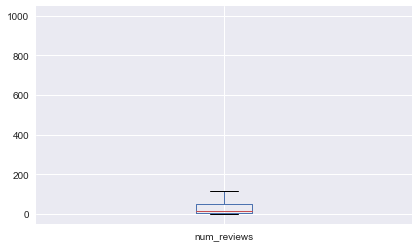

In [26]:
feat.boxplot(column=['num_reviews'])

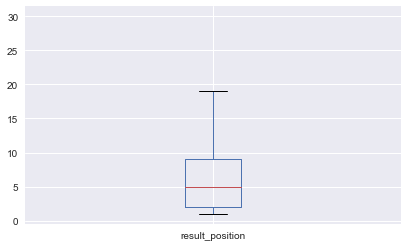

In [27]:
feat.boxplot(column=['result_position'])

Out of the three features contributing to which pro gets hired, result_position shows the biggest variance.

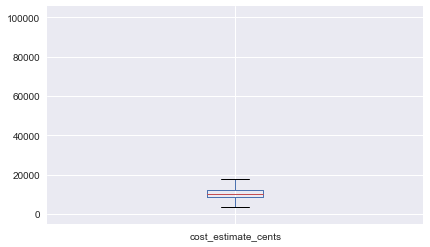

In [28]:
feat.boxplot(column=['cost_estimate_cents'])

Out of the three features, 'cost' apparently has the lowest amount of variance with the top part of the boxplot being almost as evenly out from the median as the lower portion of the boxplot is. This may hint at the quality of work from pro's since this what is usually associated with setting price.

# -Types of pros customers interested in

K-Means Clustering will be used since it is a simple approach for partitioning a data set into K distinct, non-overlapping clusters. 

In [29]:
feat.head()

,num_reviews,result_position,cost_estimate_cents,hired
14372,14,1,9000.0,0
18745,32,1,8900.0,0
18744,32,1,13800.0,0
18743,32,1,12900.0,0
18741,32,1,10500.0,0


In [30]:
#Extracting DF values, no axes
x_cols = feat.as_matrix()

# Elbow Method

Using Elbow Method to **determine how many clusters** to start KMeans algorithm. What number to choose is based on application. Choose a small number and may get too few distinguishing groups. Choose a big number and may have too many groups to manage. 

In the absence of practical considerations, statistical approach can be used. Common approach is the elbow method which is to identify when the set of clusters explains "most" of the variance in the data. Adding new clusters constributes little to variance explained. The elbow is the point where the cumulative variance explained flattens out after rising steeply, hence the name of the method.

## 4a. Data Modeling

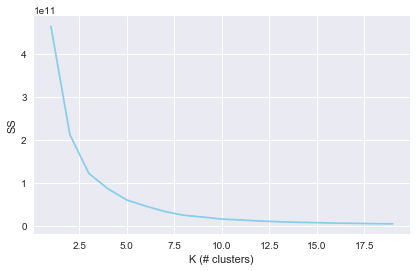

In [31]:
K_grid = range(1,20) 
SS = [] #sum of squares will be put into a list after calculations are done per cluster
for k in K_grid:
    model = KMeans(n_clusters = k) #max number of clusters will be equal to max amt of features
    model.fit_transform(x_cols) #compute clustering and transform x_cols to cluster-distance space
    SS.append(model.inertia_) #within-cluster sum-of-squares

plt.plot(K_grid, SS, color = "skyblue")
plt.xlabel("K (# clusters)")
plt.ylabel("SS")
plt.show()

The Elbow: Graph starts flattening out (when variance is reduced) after 3 to 4. I will choose 4 to be on the safe side and not under represent any groupings. Any value after this will not significantly make the sum of distance squared significantly smaller/within-cluster sum-of-squares, which is our goal when picking K.

Text(0, 0.5, '# pts')

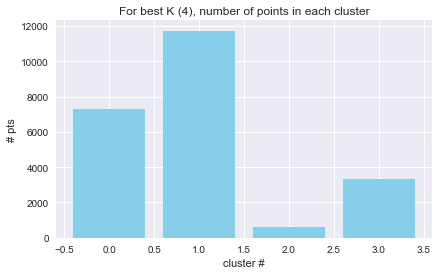

In [32]:
#Making a bar chart showing the number of points in each cluster for k-means under the best K.

best_k = 4 #This will be the K number chosen from this point even though there was another candidate. 
model = KMeans(n_clusters = best_k)
model.fit_transform(x_cols)
labels = model.labels_

x,y = zip(*Counter(labels).most_common())

plt.bar(x, y, color = 'skyblue')
plt.title("For best K (4), number of points in each cluster")
plt.xlabel("cluster #")
plt.ylabel("# pts")

One can see that one cluster will have a significant amount of points where another cluster will have a significantly small number of points.

**PCA (Principal Component Analysis)** helps to determine/reduce variables that vary together (covary). Some of the variation is one is actually duplicated by variation in another. The idea is to combine multiple predictor variables into a smaller set of variables, which are weighted linear combinations of the orignal set.

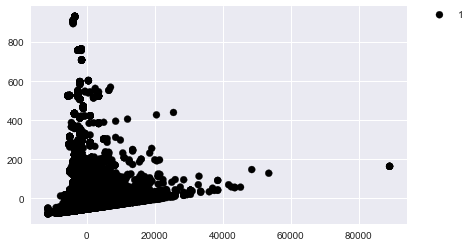

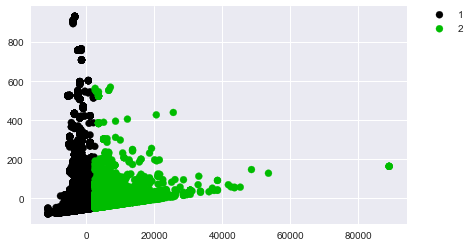

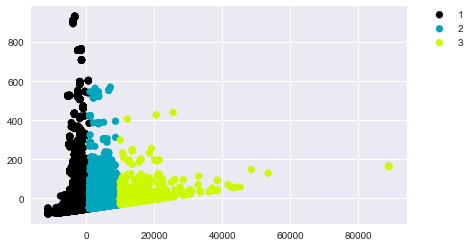

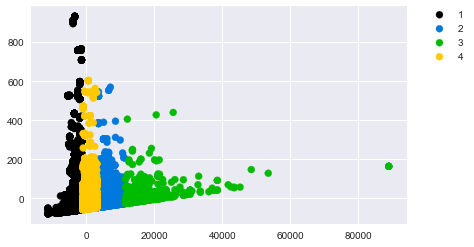

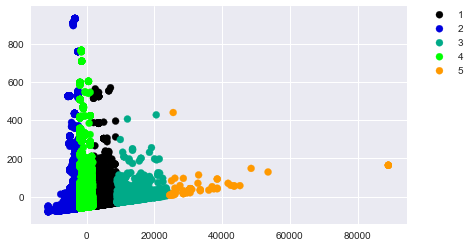

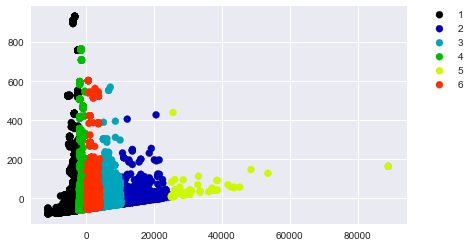

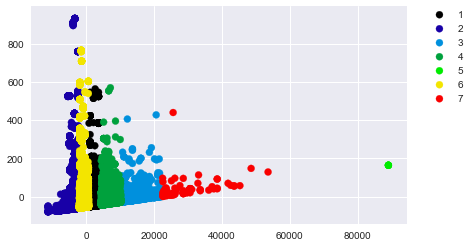

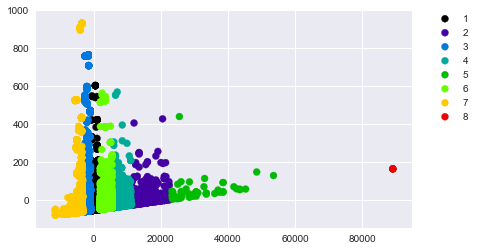

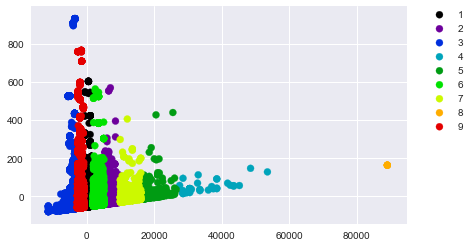

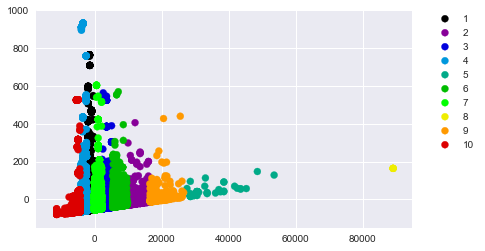

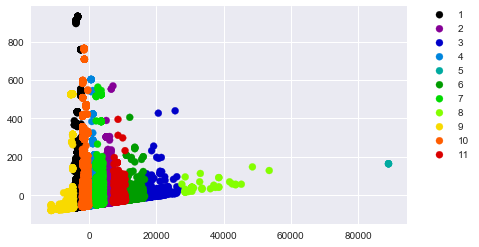

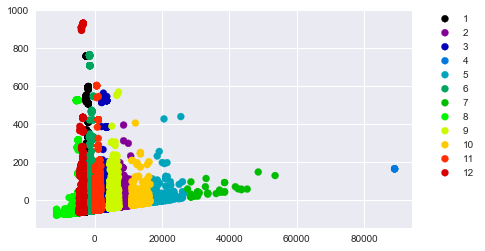

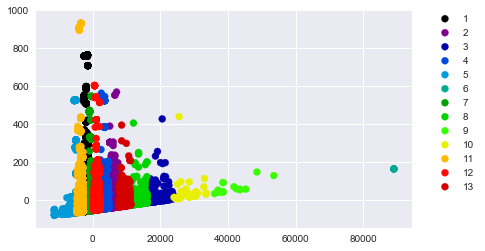

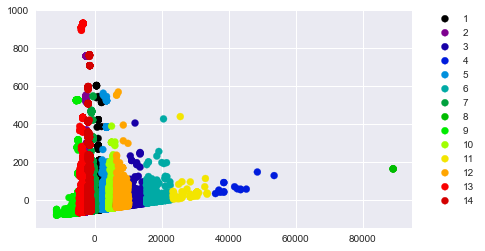

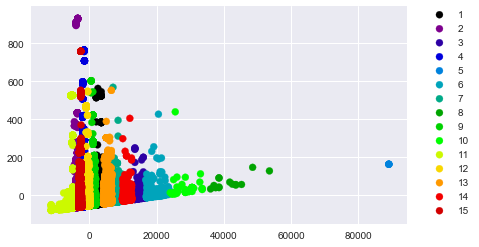

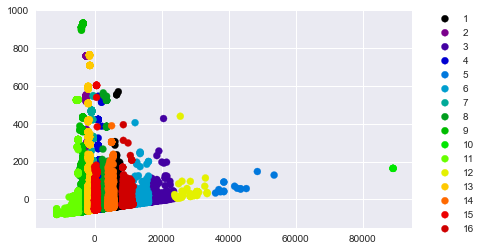

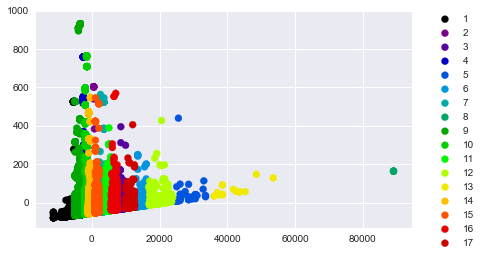

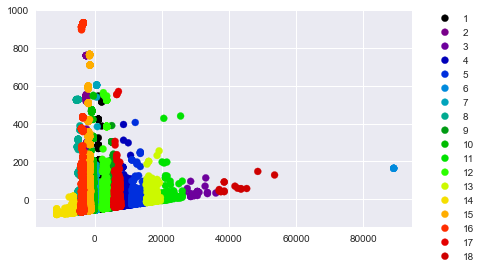

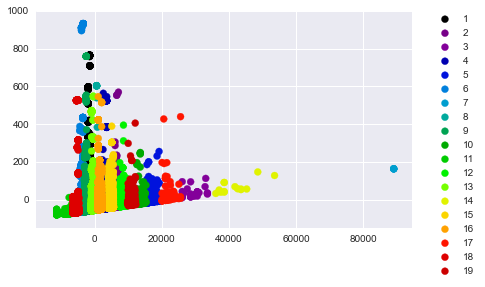

In [33]:
model = PCA(n_components=2)
x,y = zip(*model.fit_transform(x_cols))
new_table = feat.copy()
new_table['x']=x
new_table['y']=y
item_columns = new_table.columns[[range(4)]]
new_table = new_table.drop(item_columns,axis=1)

for chosen_k in K_grid:

    model = KMeans(n_clusters = chosen_k)
    model.fit_transform(x_cols)
    labels = model.labels_
    new_table['cluster_id'] = labels
    new_table.head()

    fig,ax = plt.subplots()
    for i in range(chosen_k):
        color = cm.nipy_spectral(new_table['cluster_id'][labels==i]/float(chosen_k))
        ax.scatter(new_table['x'][labels==i],new_table['y'][labels==i]
                ,color=color
                ,label=i)
    ax.legend(labels=range(1,chosen_k+1),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Based on the above output, 4 clusters, just like Elbow method showed is the optimal amount of clusters. That grouping has the most distinct groups/minimal overlapping. The best number to choose for cluster amount is where the number chosen maximizes distant between each cluster and minimizes distance of within-cluster points to the center of each cluster. 

## 5a. Model Evaluation/Story with Clusters - What Types of Pros are Customers Interested In

Please refer to attachments and comment page for futher work on K Means model clustering including which points from dataset are tied to which clusters.

### For future work with this data:

Need to normalize data or standardize continuous variables by subtracting mean and dividing by the standard deviation. Otherwise, variables with large scale will dominate the clustering process. (This can be done using sklearn's preprocessing library).

## Quality of the search results? 
## And what can be improved?

Determining whether or not search results are good can be determined by looking into **information retrieval** methods, which deals with properly returning relevant results from querying large datasets of information. Are the search results relevant, showing up as they should be? Due to only having the results of search and not the actual query, can only comment on how the search result is organized.

Having a ranking system helps having the best results show up on top of the list, which is where the user first looks to assess the anwser to their query. Determining what makes a top result or one profile rank higher than another is where differentiation between platforms come in/room for improvement. Before mentioning opportunities to improve, let us look at how pro's are ranked by checking out correlation coefficient with result_position being target variable.

How strongly tied is result_position (rank) to other features.

In [34]:
combo.corr()['result_position'].sort_values()

num_reviews           -0.265796
service_page_viewed   -0.234802
avg_rating            -0.113128
visitor_id            -0.110656
hired                  0.025234
row_number             0.029305
contact_id             0.051256
pro_user_id_y          0.052404
pro_user_id_x          0.127591
cost_estimate_cents    0.175320
result_position        1.000000
Name: result_position, dtype: float64

Based on this sorted list, the strongest factor in determining a pro's rank in search results is: **cost** with rating and number of reviews being almost at the bottom of the list. This is not so surprising since people usually prioritize spending amount as determinig factor in choosing anything. What is surprising is that num_reviews is considered so lowly. When looking at Yelp review, num_reviews and rating determine restaurant's ranking. This is the case since a customer is more confident in a 5-star rating from 100 people versus a mere 10 people. 

A suggested improvement to search result would be to increase these two features' contribution to rank number. For example, way to implement this would be to give **avg_rating and num_reviews bigger multiplier/positive weight** as it is currently in the ranking system along with keeping cost still a big contributor to where a pro is ranked in search result. 

# B) Pricing

### In order to start answering this question, need to:
    1) filter out search results that have contact_id > 0 (which were NaN's')
    2) separate DF into two different groups: House Cleaning and Local Moving

# Assumption made on data:

Functioning in a more dynamic market with greater fluctuations versus fixed price market.

## 3b. Data Preparation

In [35]:
cus_contact = combo.loc[combo['contact_id'] >0]
cus_contact.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
18743,12392,343594504382545000,2018-11-20 18:55:05.054 UTC,House Cleaning,332878437037834000,32,4.81250,2018-11-19 23:18:09.237 UTC,12900.0,1,False,3.334063e+17,3.435949e+17,0
18733,25179,343934028539707000,2018-11-24 17:13:49.733 UTC,House Cleaning,292214044077736000,32,4.59375,2018-11-24 16:05:07.392 UTC,10700.0,1,False,3.050415e+17,3.439340e+17,0
18730,25446,344202962964709000,2018-11-27 19:56:03.545 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-27 19:43:37.264 UTC,8500.0,1,True,3.337433e+17,3.442034e+17,0
18729,21985,344392815005474000,2018-11-30 00:40:15.603 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-30 00:05:18.977 UTC,8500.0,1,True,3.337433e+17,3.443930e+17,0
18727,13191,344404051764396000,2018-11-30 03:47:32.122 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-30 02:31:24.247 UTC,8500.0,1,True,3.337433e+17,3.444044e+17,0


In [36]:
cus_contact.head()

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
18743,12392,343594504382545000,2018-11-20 18:55:05.054 UTC,House Cleaning,332878437037834000,32,4.81250,2018-11-19 23:18:09.237 UTC,12900.0,1,False,3.334063e+17,3.435949e+17,0
18733,25179,343934028539707000,2018-11-24 17:13:49.733 UTC,House Cleaning,292214044077736000,32,4.59375,2018-11-24 16:05:07.392 UTC,10700.0,1,False,3.050415e+17,3.439340e+17,0
18730,25446,344202962964709000,2018-11-27 19:56:03.545 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-27 19:43:37.264 UTC,8500.0,1,True,3.337433e+17,3.442034e+17,0
18729,21985,344392815005474000,2018-11-30 00:40:15.603 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-30 00:05:18.977 UTC,8500.0,1,True,3.337433e+17,3.443930e+17,0
18727,13191,344404051764396000,2018-11-30 03:47:32.122 UTC,Local Moving (under 50 miles),333743292806455000,32,4.65625,2018-11-30 02:31:24.247 UTC,8500.0,1,True,3.337433e+17,3.444044e+17,0


In [37]:
cus_contact.sort_values(by=['search_timestamp'])

,row_number,visitor_id,search_timestamp,category,pro_user_id_x,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,pro_user_id_y,contact_id,hired
13221,8436,339208852905672000,2018-10-01 00:40:53.592 UTC,House Cleaning,213748876996502000,12,4.666667,2018-09-24 23:52:53.323 UTC,8000.0,2,True,2.137489e+17,3.392091e+17,0
12390,8435,339208852905672000,2018-10-01 00:40:53.592 UTC,House Cleaning,336772522968391000,10,5.000000,2018-09-30 18:01:30.673 UTC,8500.0,1,False,2.137489e+17,3.392091e+17,0
2153,11885,339208995230892000,2018-10-01 00:43:15.919 UTC,House Cleaning,302161162092200000,1,4.000000,2018-09-28 20:18:06.066 UTC,8000.0,2,False,2.481978e+17,3.392093e+17,1
22749,11884,339208995230892000,2018-10-01 00:43:15.919 UTC,House Cleaning,248197807486927000,590,4.679661,2018-09-30 19:43:09.781 UTC,8900.0,1,True,2.481978e+17,3.392093e+17,1
2494,24998,339210920208318000,2018-10-01 01:15:21.007 UTC,House Cleaning,337654707085500000,1,5.000000,2018-09-30 21:30:57.349 UTC,9000.0,2,True,3.376547e+17,3.392110e+17,1
12033,24999,339210920208318000,2018-10-01 01:15:21.007 UTC,House Cleaning,335069133822828000,10,4.700000,2018-09-30 20:31:44.259 UTC,10000.0,3,False,3.376547e+17,3.392110e+17,1
9987,25000,339210920208318000,2018-10-01 01:15:21.007 UTC,House Cleaning,210566639783265000,7,4.428571,2018-09-28 21:27:40.241 UTC,12500.0,4,False,3.376547e+17,3.392110e+17,1
13756,24997,339210920208318000,2018-10-01 01:15:21.007 UTC,House Cleaning,317149935595561000,13,4.538462,2018-09-30 19:31:34.954 UTC,7900.0,1,False,3.376547e+17,3.392110e+17,1
10639,21175,339215065721331000,2018-10-01 02:24:26.645 UTC,House Cleaning,335062516718297000,8,4.875000,2018-09-19 12:03:48.542 UTC,10000.0,4,False,3.342772e+17,3.392152e+17,0
5464,21181,339215065721331000,2018-10-01 02:24:26.645 UTC,House Cleaning,322436681018286000,3,5.000000,2018-09-30 14:33:53.749 UTC,12000.0,10,False,3.342772e+17,3.392152e+17,0


Initially, thought to strip search_timestamp of timestamp to reduce model x-axis clutering, but bad idea since there are different rows of search results intiated at the same millisecond or separated by few hours/minutes (possibly belonging to the same visitor). In order to not lose this granuality, decided to keep timestamp in, which makes for richer data analysis.

### Changing price column into dollar units since this is more common unit

In [38]:
cus_contact['cost_estimate_cents'] = cus_contact['cost_estimate_cents']/100

In [39]:
cus_contact = cus_contact.rename(index=str, columns={"cost_estimate_cents": "cost_estimate_dollars"})

### Renaming relevant date time stamp column and price columns to suitable titles for FB Prophet modeling

In [40]:
cus_contact = cus_contact.rename(columns={'search_timestamp': 'ds','cost_estimate_dollars': 'y'})

### Separted out dataframes for House Cleaning and for Local Moving (under 50 miles)

In [41]:
h_cus_contact = cus_contact.loc[cus_contact['category'] == "House Cleaning"]

In [42]:
l_cus_contact = cus_contact.loc[cus_contact['category'] == "Local Moving (under 50 miles)"]

### Get relevant columns to make df for FB Prophet modeling (one for House Cleaning and another one for Local Moving (under 50 miles)

In [43]:
h_cus_contact2 = h_cus_contact[['ds','y']].copy()
h_cus_contact2.head()

,ds,y
18743,2018-11-20 18:55:05.054 UTC,129.0
18733,2018-11-24 17:13:49.733 UTC,107.0
18709,2018-11-12 16:54:53.877 UTC,115.0
18706,2018-11-09 13:15:46.57 UTC,80.0
18746,2018-11-25 23:21:58.794 UTC,97.0


In [44]:
l_cus_contact2 = l_cus_contact[['ds','y']].copy()
l_cus_contact2.head()

,ds,y
18730,2018-11-27 19:56:03.545 UTC,85.0
18729,2018-11-30 00:40:15.603 UTC,85.0
18727,2018-11-30 03:47:32.122 UTC,85.0
18726,2018-11-28 17:52:12.758 UTC,85.0
18608,2018-11-15 04:45:34.35 UTC,85.0


## 4b. Modeling

## Time Series Price Prediction using Facebook's Prophet

Now that the data is ready, need to prepare it for Time Series model using Facebook's Prophet. The reason I am using a Time Series model is because pricing has very much to do with time. Dynamic price optimization is responds to changing demand of a marketplace by the minute or second. It is used on Amazon, Uber and Lyft platforms. And for Thumbtack's platform, I recommend the same so that pro's do not feel underpaid when there is a high demand. Such a case like this happens when requests for movers/cleaners spike when a college town's academic year starts/closes. With this dataset, not able to probably see a spike since the difference in season between October and November is almost negligible. However, what one can do is to detect granular fluctuations within year/month/week. And this is what Facebook Prophet is able to do. The reason why I chose to use it was due to being an additive model, deals with outliers and seasonality well and it is easy to implement.

### Will fit data to model and build prediction for House Cleaning category first.

In [45]:
m1 = Prophet()
m1.fit(h_cus_contact2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [46]:
future1 = m1.make_future_dataframe(periods=90)
future1.tail()

,ds
8225,2019-02-24 22:49:50.709
8226,2019-02-25 22:49:50.709
8227,2019-02-26 22:49:50.709
8228,2019-02-27 22:49:50.709
8229,2019-02-28 22:49:50.709


In [47]:
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8225,2019-02-24 22:49:50.709,122.910346,-72.865435,338.533475
8226,2019-02-25 22:49:50.709,114.521108,-91.107152,333.492099
8227,2019-02-26 22:49:50.709,112.439703,-91.812191,335.562764
8228,2019-02-27 22:49:50.709,115.567732,-93.865201,339.780584
8229,2019-02-28 22:49:50.709,120.899668,-93.544396,351.223465


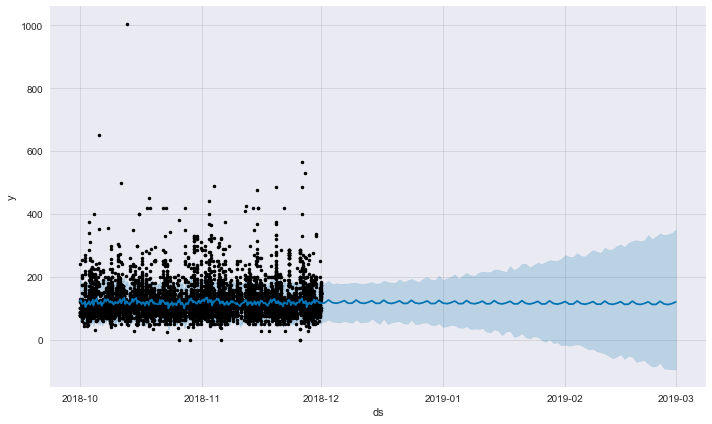

In [48]:
fig1a = m1.plot(forecast1)

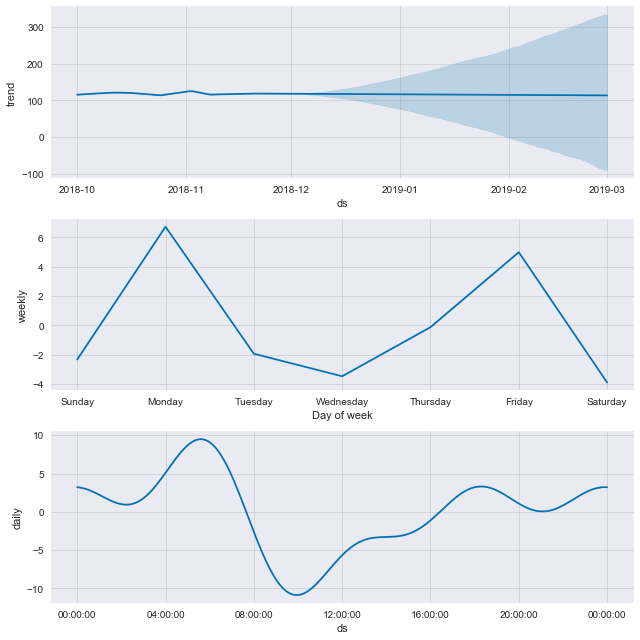

In [49]:
fig2a = m1.plot_components(forecast1)

In [50]:
df_cv1 = cross_validation(m1, initial = '20 days', horizon= '30 days')

df_pm1 = performance_metrics(df_cv1)

df_pm1.head()

INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2018-10-31 22:49:50.709000 and 2018-10-31 22:49:50.709000


,horizon,mse,rmse,mae,mape,coverage
434,2 days 19:25:44.559000,2933.070858,54.157833,36.118427,0.273215,0.875862
435,2 days 19:25:44.559000,2932.099881,54.148868,36.087341,0.272904,0.875862
436,2 days 19:25:44.559000,2963.853138,54.441282,36.298295,0.273343,0.873563
441,2 days 19:55:16.742000,2960.612048,54.411507,36.258501,0.272661,0.873563
440,2 days 19:55:16.742000,2961.120941,54.416183,36.266668,0.272444,0.873563


## 5b. Evalutation - House Cleaning Pricing Model

Some initial comments: As mentioned earlier, outliers are exposed due to granularity of FB prophet. Earlier, boxplot was used to visualize distribution of price. And based on that graph, price distribution looked even (no extreme values). However, we can see with the first graph, there are some pro's charging a bit higher possibly due to having more experience than others on the platform or fearful that they will not make a profit.

There is not much shown for yearly graph (second graph) besides a small hump at the beginning of November.

On a weekly basis, House Cleaning prices peak during Monday and Friday and during the day early in the morning and a little bit when people come back from home. This is in line with when people are usually able to get things done- not in the middle of the week or middle of the day, but what works around their job schedule. So it would make sense that prices would act according to this demand curve.

Lastly, the **performance metric RMSE** shows that predictions were not very good (RMSE = 52) since a low RMSE is what defines predictions being close to the original data. In the first graph, confidence bounds by y hat (light blue shades set at 80%) increase with later predictions in order to cover outlier points. In order to build a better model, I would get rid of outliers to have less variance. I would also cross-validate during training in order to generalize the model to better predict on unseen data and produce a lower RMSE, such as less than 1. At the same time, this goes against changing market moves of demand and therefore, supply. When producing a general model, the assumption is that most prices are fixed. The reason for the low pricing at $1 from the original dataset could have very been manual error or someone just wanted to start getting hired as soon as possible and once they got enough jobs (by increasing in rank in search results) and build enough reputation (increased rating/no reviews), they could increase price value and gain more revenue in Thumbtack market.

Comparison between House Moving original data and predictions (y hat):

In [51]:
h_cus_contact2['y'].min(), h_cus_contact2['y'].mean(), h_cus_contact2['y'].max()

(1.0, 119.33783783783784, 1005.0)

In [52]:
forecast1['yhat'].min(), forecast1['yhat'].mean(), forecast1['yhat'].max()

(100.20964814954357, 119.32478210186001, 135.21651669961304)

By looking at the initial data points and points output from model, I can see the reason for high RMSE is due to original dataset having extremely high variance. Next training would exclude these points.(Boxplots did not indicate such variability. This is why Facebook Prophet is such a great tool. It visually depicts these sort of granular inconsistencies that are not seen prior to modeling.) On the good side, Prophet smoothed out price trends. 

So **price I think Thumbtack should charge pros for House Cleaning for each customer contact is between 100 and 135 dollars**, which is the min and max prices from forecasted dataset. This range could better maximize pro's revenue, which would aid in healthy market on their end.

### Now will fit data to model and build prediction for Local Moving (under 50 miles) category.

In [53]:
m2 = Prophet()
m2.fit(l_cus_contact2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [54]:
future2 = m2.make_future_dataframe(periods=90)
future2.tail()

,ds
3224,2019-02-24 23:34:19.935
3225,2019-02-25 23:34:19.935
3226,2019-02-26 23:34:19.935
3227,2019-02-27 23:34:19.935
3228,2019-02-28 23:34:19.935


In [55]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3224,2019-02-24 23:34:19.935,65.807402,24.577035,106.658269
3225,2019-02-25 23:34:19.935,64.175472,21.677147,105.171357
3226,2019-02-26 23:34:19.935,62.551609,21.808166,106.260155
3227,2019-02-27 23:34:19.935,63.180574,20.780833,108.766173
3228,2019-02-28 23:34:19.935,68.495465,28.244357,110.817465


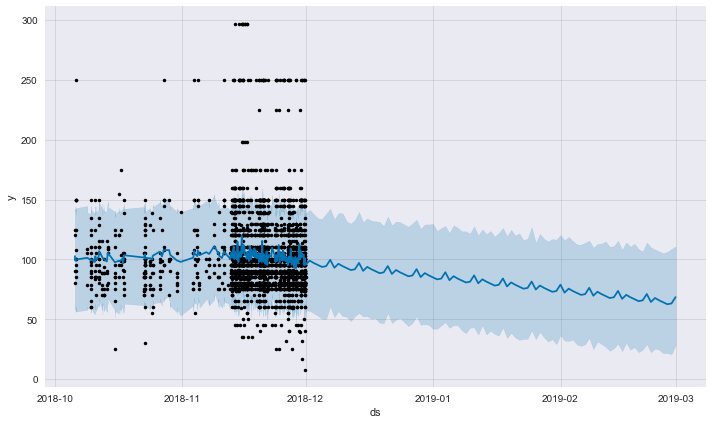

In [56]:
fig1b = m2.plot(forecast2)

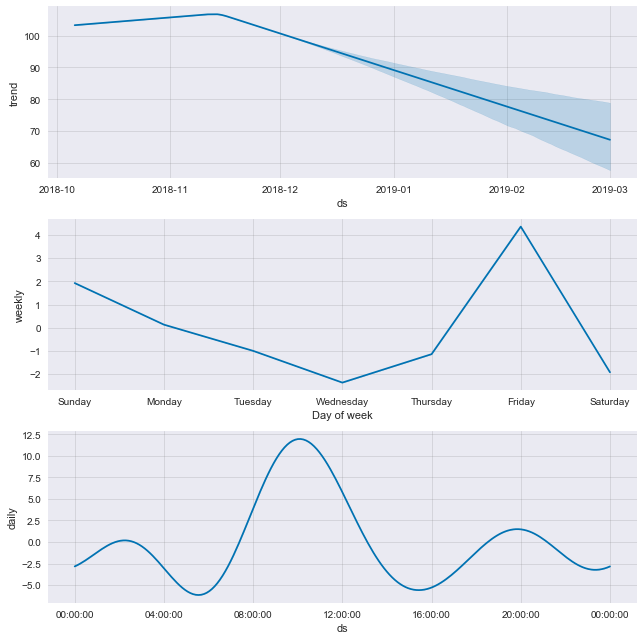

In [57]:
fig2b = m2.plot_components(forecast2)

In [59]:
df_cv2 = cross_validation(m2, initial = '20 days', horizon= '30 days')

df_pm2 = performance_metrics(df_cv2)

df_pm2.head()

INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2018-10-31 23:34:19.935000 and 2018-10-31 23:34:19.935000


,horizon,mse,rmse,mae,mape,coverage
290,12 days 18:28:36.474000,2714.011802,52.096178,35.907143,0.305295,0.591065
291,12 days 18:28:36.474000,2713.879662,52.094910,35.903220,0.305585,0.591065
296,12 days 18:31:15.994000,2713.821378,52.094351,35.899045,0.305551,0.591065
297,12 days 18:31:15.994000,2713.296286,52.089311,35.863941,0.305078,0.591065
295,12 days 18:31:15.994000,2712.972566,52.086203,35.847734,0.304806,0.591065


## Evaluation - Local Moving (under 50 miles) Pricing Model

Some intial comments on Local Moving (under 50 miles): Pricing data points are more spread out since people move varying volumes of things and at different times. Hence there is a huge range not just for pro's quality of work, but also for type of task. 

(According to the yearly graph, there seems to be a downward trend. However, this may be an extreme extrapolation since the prediction was made for 3 months, using only two months worth of data).

Looking at the weekly and daily graphs though, things make more sense since high volume of moving is usually on the weekends when people are free and not so early in the morning (mid-morning such as around 10:00 AM) and a little bit after dinner (8:00 PM). 

Comparison between original Local Moving data and predictions (y hat):

In [60]:
l_cus_contact2['y'].min(), l_cus_contact2['y'].mean(), l_cus_contact2['y'].max()

(8.0, 102.03918445364766, 297.0)

In [61]:
forecast2['yhat'].min(),forecast2['yhat'].mean(), forecast2['yhat'].max()

(62.55160895330742, 101.43797583486551, 119.6953562789619)

Performance metric for Prophet model is high again (RMSE = 50). After looking at original data compared to predicted data (y hat), see that the reason for huge RMSE is that the difference between min and max values between original and predicted data is high. There is huge variability in the original data whereas the predicted values are smoothed out. Therefore, the **price I think Thumbtack should charge for Local Moving pros for each customer contact is between 62 and 120 dollars**, min and max values from predicted data which could very meet fluctuations in market and increase revenue for pro's, which is their goal on Thumbtack's platform.

In the end, correctly giving someone relevant search results helps move a visitor along Thumbtack's platform in order to eventually become a customer. So it would be best to optimize search results to be as relevant as possible and also even give visitor more than they intended to get in a search result such as recommended jobs/recommended pro's based on initial search. 
And setting the price of work in order to please both sides of the market is crucial. On one side you want the pro to maximize revenue and on the other side of the market, you want the customer to want to come back on the Thumbtack platform due to not paying as much for same service offered by competitors. At the same time, pricing in a dynamic market is imporant because pricing can change quickly due to spikes in demand/supply. These things are to be considered when building a platform to hire service professionals whenever you want and to make it hassle free for the customer.